# Business Understanding

## Project Domain

Studi kasus ini berada di domain penjualan elektronik konsumen, khususnya televisi. Forecasting penjualan TV sangat penting bagi perusahaan untuk mengoptimalkan inventaris, meningkatkan efisiensi rantai pasokan, dan merancang strategi pemasaran yang efektif.

## Problem Statements

Perusahaan menghadapi tantangan dalam:

Memastikan stok TV tersedia dalam jumlah tepat tanpa overstock maupun stock-out.

Menyesuaikan strategi distribusi dan promosi berdasarkan tren penjualan yang berubah-ubah.

Menghadapi fluktuasi permintaan yang dipengaruhi oleh waktu, musim, model TV tertentu, dan faktor eksternal.

Tanpa prediksi penjualan yang akurat, perusahaan berisiko kehilangan penjualan atau menanggung biaya gudang berlebih.

## Goals

Membuat model prediksi penjualan TV berdasarkan data historis penjualan.

Mengidentifikasi pola musiman atau tren waktu yang memengaruhi permintaan.

Memberikan wawasan untuk pengambilan keputusan bisnis, seperti:

Berapa banyak unit yang harus disiapkan untuk bulan berikutnya.

Model TV mana yang paling stabil penjualannya.

Waktu puncak dan penurunan penjualan dalam setahun.




## Solution Statements

Menggunakan pendekatan machine learning atau deep learning (LSTM) untuk membuat model time series forecasting dari dataset penjualan berdasarkan tanggal dan model TV.

Membersihkan dan mengolah data, mengatur skala, serta membentuk fitur-fitur yang relevan (seperti tren, musiman, dan variabel waktu).

Melatih model prediktif dan mengevaluasi kinerjanya menggunakan metrik seperti RMSE atau MAPE.

Menyajikan hasil prediksi dalam bentuk grafik dan tabel untuk mendukung keputusan manajerial.

# Data Understanding

## Import data dari kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saffanahrajbiah","key":"8859251281f5fb7dbb3d6092fd125858"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d nomanvb/tv-sales-forecast

Dataset URL: https://www.kaggle.com/datasets/nomanvb/tv-sales-forecast
License(s): DbCL-1.0
  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 489MB/s]


In [4]:
!mkdir tv-sales-forecast
!unzip tv-sales-forecast.zip -d tv-sales-forecast
!ls tv-sales-forecast

Archive:  tv-sales-forecast.zip
  inflating: tv-sales-forecast/Date and model wise sale.csv  
'Date and model wise sale.csv'


## Import Library yang dibutuhkan

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

In [6]:
df = pd.read_csv('tv-sales-forecast/Date and model wise sale.csv')


In [7]:
df.head()

,Date,Model,Count
0,31-Aug-16,M45,5
1,31-Aug-16,M121,3
2,31-Aug-16,M122,4
3,31-Aug-16,M91,10
4,31-Aug-16,M66,57


In [8]:
df.columns

Index(['Date', 'Model', 'Count'], dtype='object')

## Exploratory Data Analysis

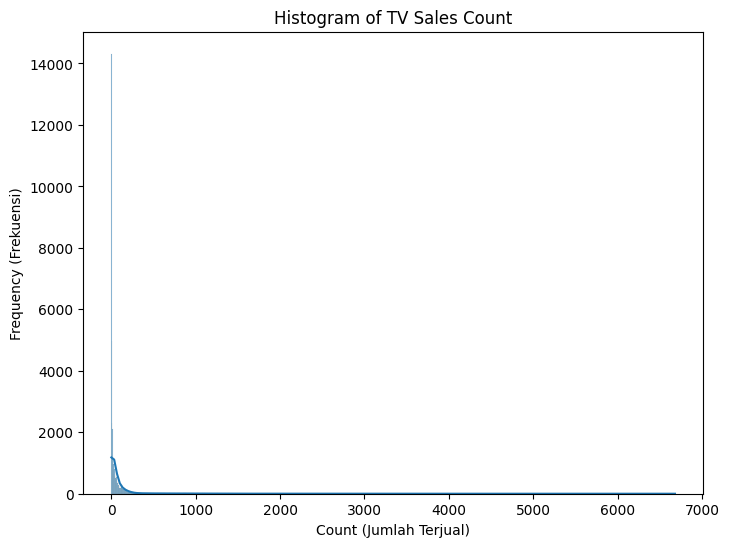

In [13]:
# histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['Count'], kde=True)
plt.title('Histogram of TV Sales Count')
plt.xlabel('Count (Jumlah Terjual)')
plt.ylabel('Frequency (Frekuensi)')
plt.show()

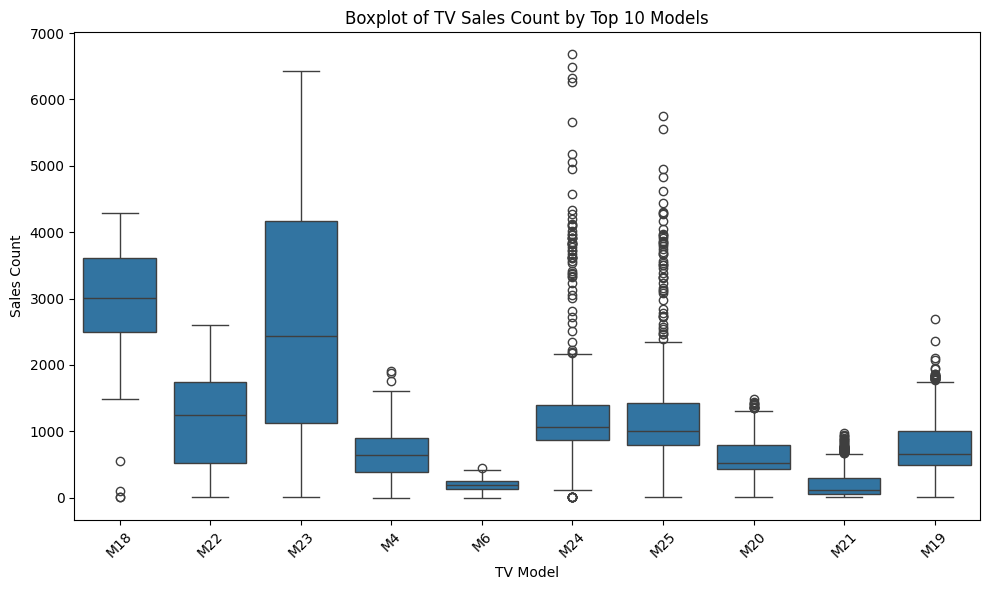

In [14]:
# box plot
top10_models = df.groupby('Model')['Count'].sum().sort_values(ascending=False).head(10).index
df_top10 = df[df['Model'].isin(top10_models)]
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Count', data=df_top10)
plt.title('Boxplot of TV Sales Count by Top 10 Models')
plt.xlabel('TV Model')
plt.ylabel('Sales Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-15-47199992>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


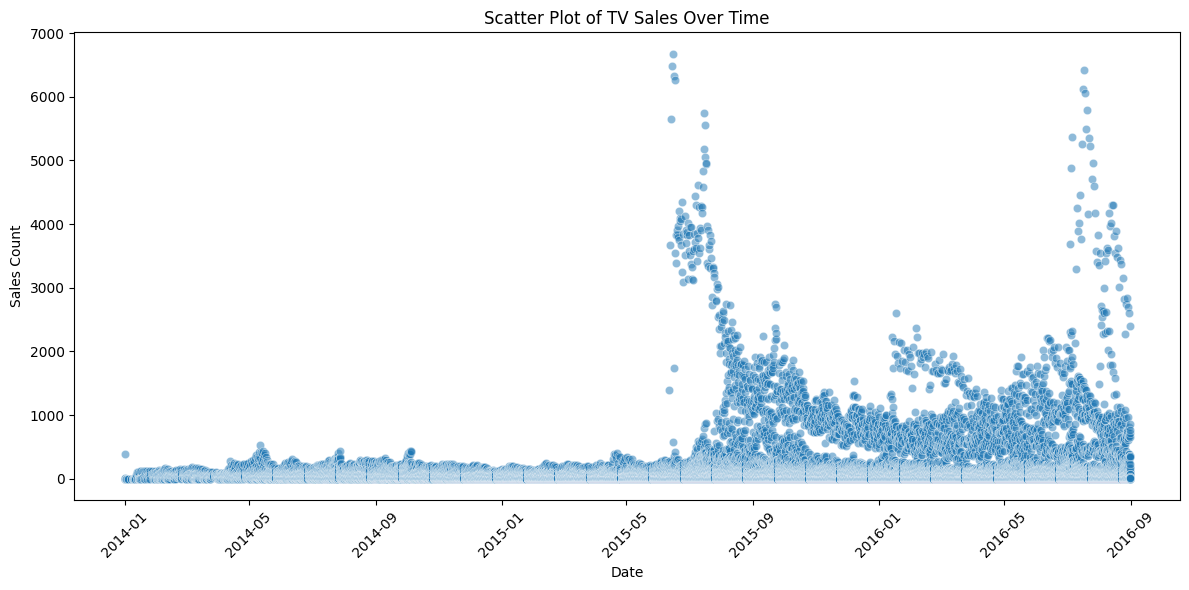

In [15]:
# Scatter Plot
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Date', y='Count', data=df, alpha=0.5)
plt.title('Scatter Plot of TV Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

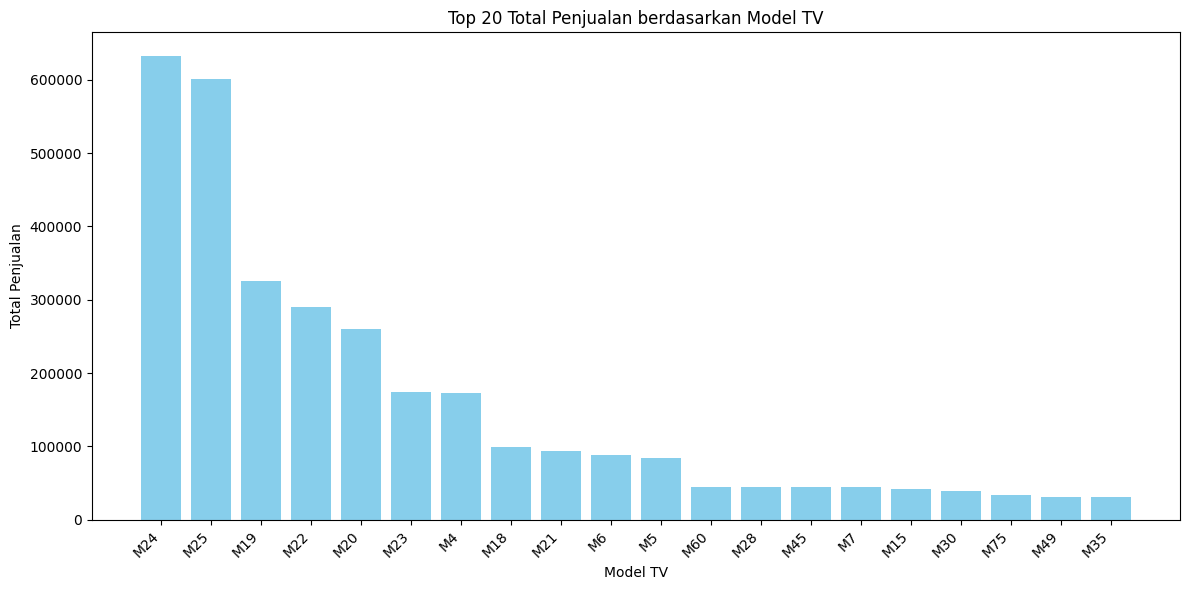

In [16]:
# Bar Chart
model_counts = df.groupby('Model')['Count'].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 6))
plt.bar(model_counts.index, model_counts.values, color='skyblue')
plt.xlabel('Model TV')
plt.ylabel('Total Penjualan')
plt.title('Top 20 Total Penjualan berdasarkan Model TV')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

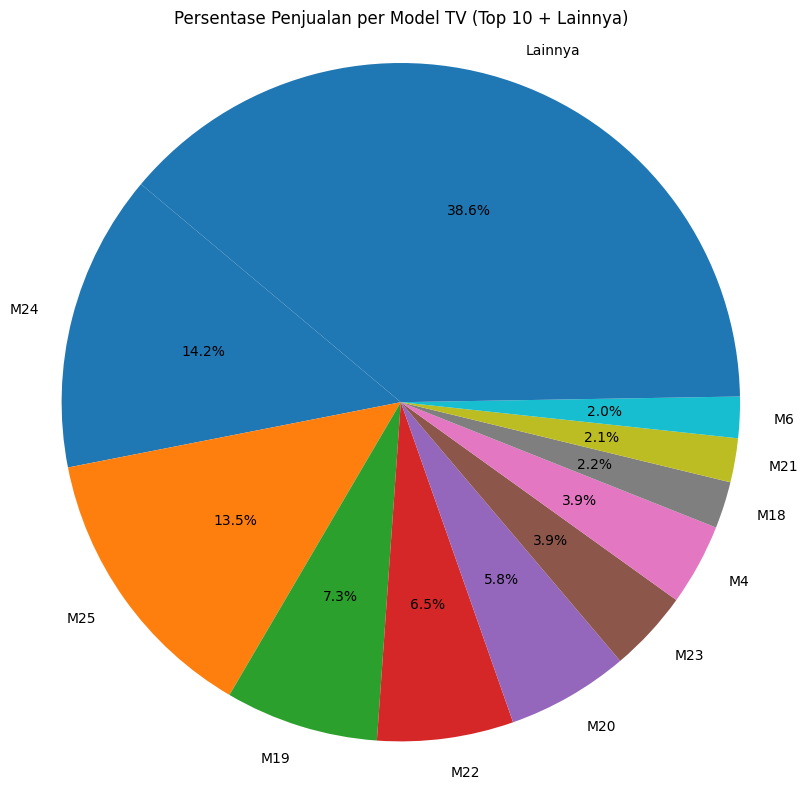

In [17]:
# Pie Chart
model_counts = df.groupby('Model')['Count'].sum().sort_values(ascending=False)
top_models = model_counts.head(10)
other_sum = model_counts[10:].sum()
# Gabungkan ke dalam satu dictionary
pie_data = top_models.copy()
pie_data['Lainnya'] = other_sum
plt.figure(figsize=(8, 8))
plt.pie(pie_data.values, labels=pie_data.index, autopct='%1.1f%%', startangle=140)
plt.title('Persentase Penjualan per Model TV (Top 10 + Lainnya)')
plt.axis('equal')  # Biar pie chart-nya bulat
plt.tight_layout()
plt.show()

# Data Preparation

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df_daily = df.groupby('Date')[['Count']].sum().reset_index()
df_daily.set_index('Date', inplace=True)


<ipython-input-9-22048186>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [10]:
import joblib

y = df_daily['Count'].ffill().values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y)
joblib.dump(scaler, 'scaler.pkl')
files.download("scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
n_lookback = 60
n_forecast = 120
X = []
Y = []

for i in range(n_lookback, len(y_scaled) - n_forecast + 1):
    X.append(y_scaled[i - n_lookback:i])
    Y.append(y_scaled[i:i + n_forecast])

X = np.array(X)
Y = np.array(Y)


# Modeling

In [12]:
from tensorflow.keras.layers import LSTM, Dropout, Dense

model = Sequential()

# LSTM pertama (return_sequences=True karena dilanjutkan oleh LSTM)
model.add(LSTM(
    units=64,
    return_sequences=True,
    activation='tanh',
    recurrent_activation='sigmoid',
    implementation=1,
    unroll=True,
    input_shape=(n_lookback, 1)
))
model.add(Dropout(0.2))

# LSTM kedua (default return_sequences=False)
model.add(LSTM(
    units=32,
    activation='tanh',
    recurrent_activation='sigmoid',
    implementation=1,
    unroll=True
))
model.add(Dropout(0.2))

# Output layer (langsung ke n_forecast)
model.add(Dense(n_forecast))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │         3,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,272 (129.97 KB)

 Trainable params: 33,272 (129.97 KB)

 Non-trainable params: 0 (0.00 B)

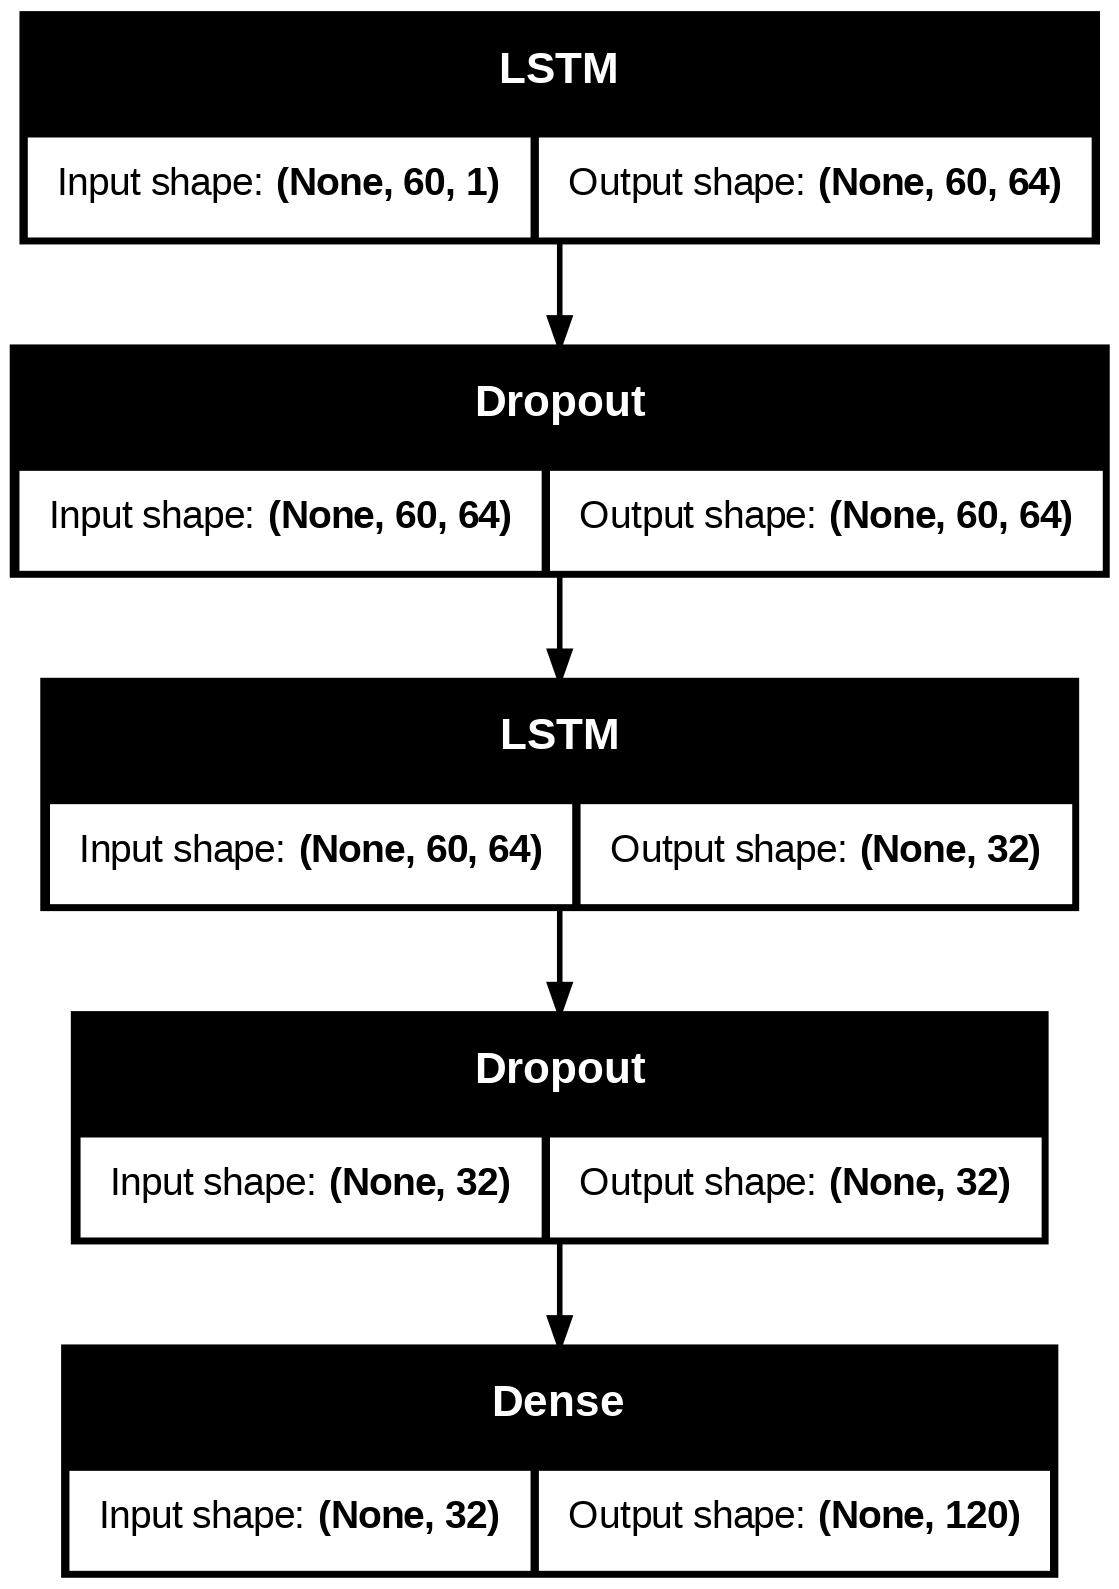

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True)

In [15]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
model.fit(X, Y, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - loss: 0.0753 - val_loss: 0.0483
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0316 - val_loss: 0.0226
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0232 - val_loss: 0.0306
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0214 - val_loss: 0.0240
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0213 - val_loss: 0.0342
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0195 - val_loss: 0.0285
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0188 - val_loss: 0.0265
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0186 - val_loss: 0.0272
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0189 - val_loss: 0.0245
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0197 - val_loss: 0.0279
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0171 - val_loss: 0.0259
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/st

In [17]:
X_ = y[ - n_lookback:] # urutan inputan terakhir
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


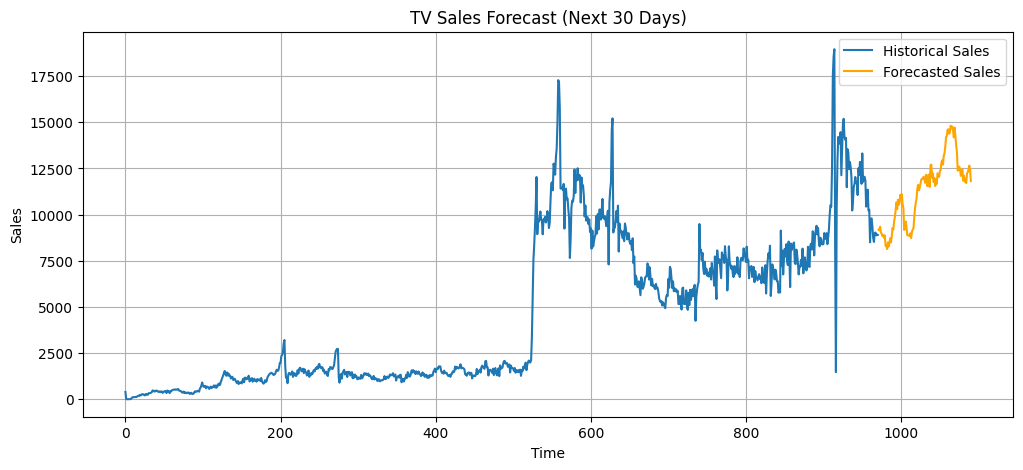

In [18]:
Y_flat = Y_.flatten()

plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(y)), y, label='Historical Sales')
plt.plot(np.arange(len(y), len(y) + n_forecast), Y_flat, label='Forecasted Sales', color='orange')
plt.title("TV Sales Forecast (Next 30 Days)")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()


# Evaluation

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

# Siapkan data evaluasi
X_eval_input = y_scaled[-n_lookback - n_forecast:-n_forecast].reshape(1, n_lookback, 1)
y_pred_scaled = model.predict(X_eval_input)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
y_true = y[-n_forecast:].flatten()

# Evaluasi
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
smape_score = smape(y_true, y_pred)
accuracy = 100 - smape_score

# Output
print("=== Evaluation Metrics ===")
print(f"RMSE        : {rmse:.2f}")
print(f"MAE         : {mae:.2f}")
print(f"SMAPE       : {smape_score:.2f}%")
print(f"Accuracy    : {accuracy:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
=== Evaluation Metrics ===
RMSE        : 3998.31
MAE         : 3115.62
SMAPE       : 33.80%
Accuracy    : 66.20%


# Deployment

## Model Simulation

## Save Model

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Buat & latih model (contoh sederhana)
model = Sequential([
    LSTM(32, input_shape=(10, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
# model.fit(x_train, y_train, epochs=10)  # <-- kalau kamu punya data

# 2. Langsung konversi ke TFLite dari model di memori
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter.experimental_enable_resource_variables = True

tflite_model = converter.convert()

# 3. Simpan file TFLite
with open('tv_sales_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ Berhasil konversi langsung ke .tflite tanpa .h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved artifact at '/tmp/tmpdlqgqyyz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 1), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133739442919504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133739442916240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133739442918352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133739442917008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133739442917968: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Berhasil konversi langsung ke .tflite tanpa .h5
